In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

In [2]:
df = pd.read_csv("/kaggle/input/contradiction-score-round/balanced_data_with_rounded_severity.csv")

In [3]:
df.head()

,hypothesis,premise,s1,s2,label,contradiction_severity_score,Unnamed: 6,viral
0,the paper is clearly written and to my knowled...,while the paper is very clear with respects to...,negative,positive,1,3.0,NaN,mihir
1,trannorm is well motivated separately normaliz...,this line of attack against the domain-adaptat...,negative,positive,1,5.0,NaN,NaN
2,active perception and more specifically recogn...,i am not convinced about the novelty and contr...,negative,positive,1,5.0,NaN,0: Non Contradicting
3,in other words the proposed method makes sense...,the topic of the paper is interesting and the ...,negative,positive,1,4.0,NaN,1: Contradicting
4,- experimental results are quite promising as ...,furthermore evaluations seem rather noisy to m...,negative,positive,1,5.0,NaN,NaN


In [4]:
count_0 = df[df['label'] == 0].shape[0]

count_1 = df[df['label'] == 1].shape[0]

print("Number of rows where 'label' is 0:", count_0)
print("Number of rows where 'label' is 1:", count_1)

Number of rows where 'label' is 0: 16007
Number of rows where 'label' is 1: 5725


In [5]:
df.shape

(21732, 8)

In [6]:
X = df[['hypothesis', 'premise']]
y_label = df['label']
y_severity = df['contradiction_severity_score']

In [7]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_label_resampled = ros.fit_resample(X, y_label)
y_severity_resampled = y_severity.loc[y_label.index[ros.sample_indices_]]

In [8]:
X_train, X_test, y_train_label, y_test_label, y_train_severity, y_test_severity = train_test_split(
    X_resampled, y_label_resampled, y_severity_resampled, test_size=0.3, random_state=42
)

In [9]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
scibert_model = TFAutoModel.from_pretrained("allenai/scibert_scivocab_uncased", from_pt=True)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_severity = scaler.fit_transform(y_train_severity.values.reshape(-1, 1)).flatten()
y_test_severity = scaler.transform(y_test_severity.values.reshape(-1, 1)).flatten()

In [11]:
MAX_LEN = 128

def encode_texts(texts):
    return tokenizer(
        texts.tolist(), padding=True, truncation=True, max_length=MAX_LEN, return_tensors='tf'
    )

In [12]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1],), initializer="random_normal")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.tensordot(x, self.W, axes=(2, 0)))
        a = tf.keras.backend.softmax(e)
        output = x * tf.expand_dims(a, -1)
        return tf.keras.backend.sum(output, axis=1)

In [13]:
def build_model():
    input_ids_hyp = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids_hyp')
    attention_mask_hyp = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask_hyp')
    input_ids_prem = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids_prem')
    attention_mask_prem = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask_prem')

    def scibert_output(x):
        return scibert_model(input_ids=x[0], attention_mask=x[1])[0]

    scibert_output_hyp = tf.keras.layers.Lambda(
        scibert_output, output_shape=(MAX_LEN, scibert_model.config.hidden_size)
    )([input_ids_hyp, attention_mask_hyp])

    scibert_output_prem = tf.keras.layers.Lambda(
        scibert_output, output_shape=(MAX_LEN, scibert_model.config.hidden_size)
    )([input_ids_prem, attention_mask_prem])

    lstm_hyp = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(scibert_output_hyp)
    lstm_prem = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(scibert_output_prem)

    att_hyp = AttentionLayer()(lstm_hyp)
    att_prem = AttentionLayer()(lstm_prem)

    concatenated = tf.keras.layers.Concatenate()([att_hyp, att_prem])

    shared_dense = tf.keras.layers.Dense(64, activation='relu')(concatenated)

    label_output = tf.keras.layers.Dense(1, activation='sigmoid', name='label_output')(shared_dense)
    severity_output = tf.keras.layers.Dense(1, activation='linear', name='severity_output')(shared_dense)

    model = tf.keras.Model(
        inputs=[input_ids_hyp, attention_mask_hyp, input_ids_prem, attention_mask_prem],
        outputs=[label_output, severity_output]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss={
            'label_output': 'binary_crossentropy',
            'severity_output': 'mse'
        },
        metrics={
            'label_output': 'accuracy',
            'severity_output': 'mae'
        }
    )

    return model

In [14]:
def create_dataset(X, y_label, y_severity, batch_size=16):
    hypotheses_enc = encode_texts(X['hypothesis'])
    premises_enc = encode_texts(X['premise'])

    return tf.data.Dataset.from_tensor_slices((
        {
            'input_ids_hyp': hypotheses_enc['input_ids'],
            'attention_mask_hyp': hypotheses_enc['attention_mask'],
            'input_ids_prem': premises_enc['input_ids'],
            'attention_mask_prem': premises_enc['attention_mask']
        },
        {
            'label_output': y_label,
            'severity_output': y_severity
        }
    )).shuffle(len(X)).batch(batch_size)

In [15]:
train_dataset = create_dataset(X_train, y_train_label, y_train_severity)
test_dataset = create_dataset(X_test, y_test_label, y_test_severity)

In [16]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_hyp (InputLayer)  [(None, 128)]                0         []                            
                                                                                                  
 attention_mask_hyp (InputL  [(None, 128)]                0         []                            
 ayer)                                                                                            
                                                                                                  
 input_ids_prem (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

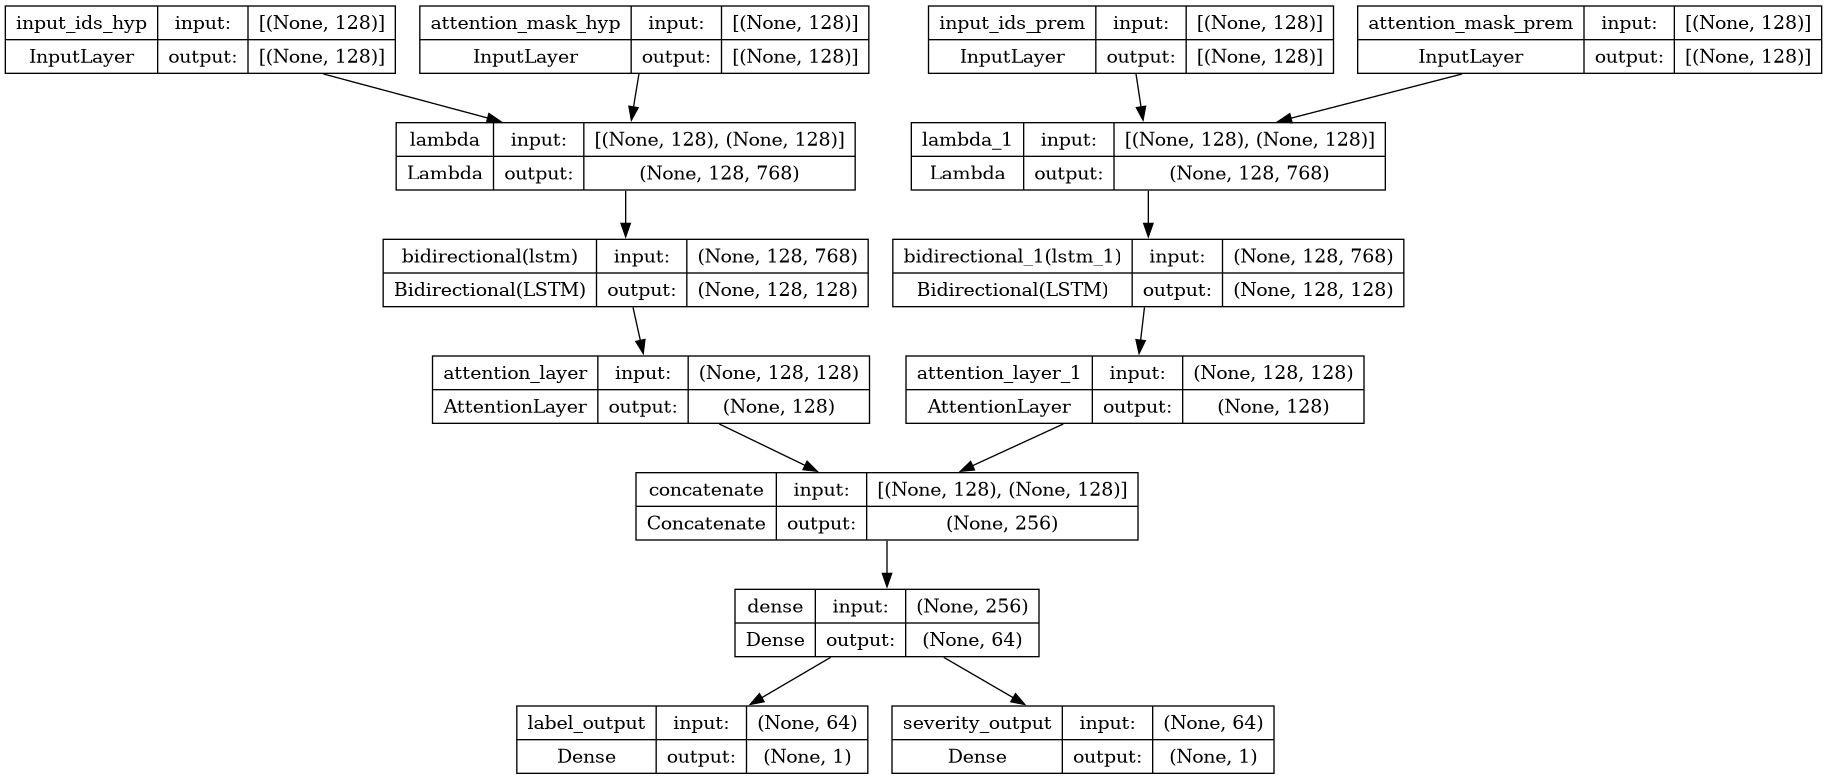

In [17]:
tf.keras.utils.plot_model(model,to_file='multi-task_model.png', show_shapes=True)

In [18]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3),
        tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.keras', save_best_only=True, monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs')
    ]
)

Epoch 1/10


I0000 00:00:1725951390.552826      71 service.cc:145] XLA service 0x7820d541f720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725951390.552881      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725951390.552885      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725951390.714937      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1401/1401 [==============================] - 718s 448ms/step - loss: 0.7722 - label_output_loss: 0.6717 - severity_output_loss: 0.1005 - label_output_accuracy: 0.5813 - severity_output_mae: 0.2877 - val_loss: 0.7380 - val_label_output_loss: 0.6487 - val_severity_output_loss: 0.0892 - val_label_output_accuracy: 0.6252 - val_severity_output_mae: 0.2699
Epoch 2/10
1401/1401 [==============================] - 605s 432ms/step - loss: 0.7254 - label_output_loss: 0.6378 - severity_output_loss: 0.0876 - label_output_accuracy: 0.6370 - severity_output_mae: 0.2658 - val_loss: 0.7042 - val_label_output_loss: 0.6194 - val_severity_output_loss: 0.0848 - val_label_output_accuracy: 0.6551 - val_severity_output_mae: 0.2576
Epoch 3/10
1401/1401 [==============================] - 604s 431ms/step - loss: 0.6973 - label_output_loss: 0.6142 - severity_output_loss: 0.0830 - label_output_accuracy: 0.6647 - severity_output_mae: 0.2554 - val_loss: 0.6815 - val_label_output_loss: 0.6003 - val_severity_output_lo

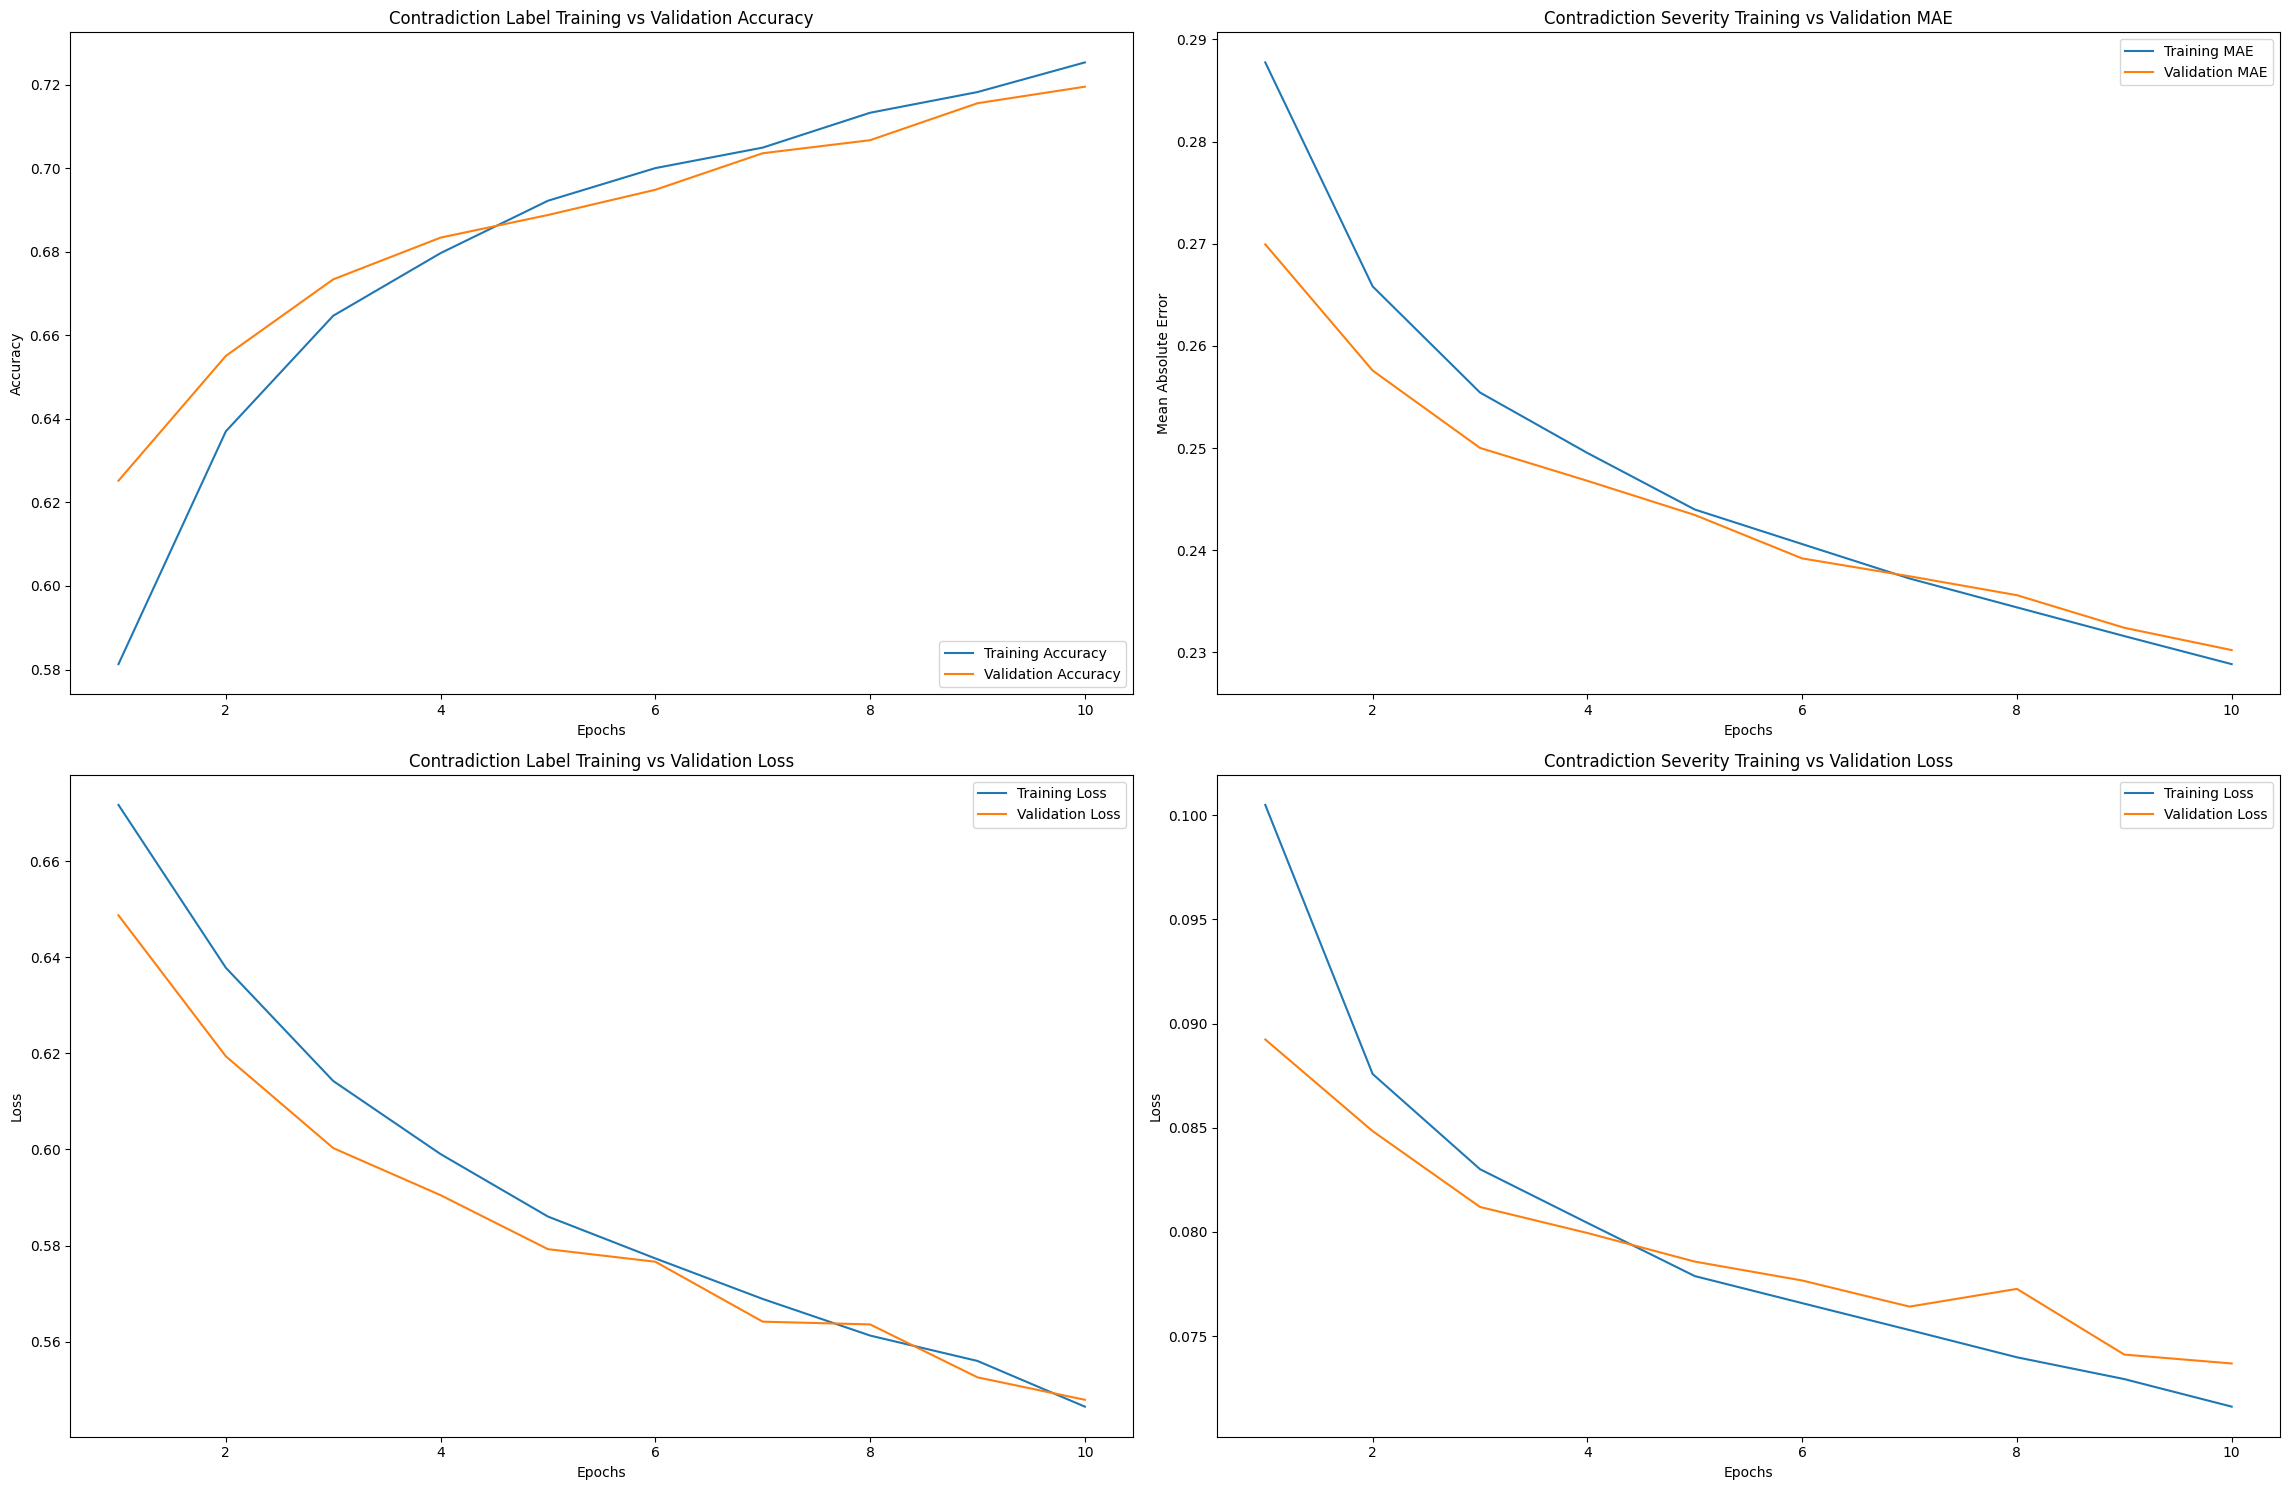

In [19]:
import matplotlib.pyplot as plt

# Extract metrics from history
metrics = history.history
epochs_range = range(1, len(metrics['loss']) + 1)

plt.figure(figsize=(23, 15))

# Label Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs_range, metrics['label_output_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, metrics['val_label_output_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Contradiction Label Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Severity MAE
plt.subplot(2, 2, 2)
plt.plot(epochs_range, metrics['severity_output_mae'], label='Training MAE')
plt.plot(epochs_range, metrics['val_severity_output_mae'], label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Contradiction Severity Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

# Label Loss
plt.subplot(2, 2, 3)
plt.plot(epochs_range, metrics['label_output_loss'], label='Training Loss')
plt.plot(epochs_range, metrics['val_label_output_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Contradiction Label Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Severity Loss
plt.subplot(2, 2, 4)
plt.plot(epochs_range, metrics['severity_output_loss'], label='Training Loss')
plt.plot(epochs_range, metrics['val_severity_output_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Contradiction Severity Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [20]:
test_loss, test_label_loss, test_severity_loss, test_label_acc, test_severity_mae = model.evaluate(test_dataset)
print(f"Test Label Accuracy: {test_label_acc:.4f}")
print(f"Test Severity MAE: {test_severity_mae:.4f}")

601/601 [==============================] - 171s 284ms/step - loss: 0.6216 - label_output_loss: 0.5479 - severity_output_loss: 0.0737 - label_output_accuracy: 0.7195 - severity_output_mae: 0.2302
Test Label Accuracy: 0.7195
Test Severity MAE: 0.2302


In [21]:
def predict_contradiction_and_severity(hypothesis, premise, model):
    hyp_enc = tokenizer(hypothesis, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')
    prem_enc = tokenizer(premise, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='tf')

    inputs = {
        'input_ids_hyp': hyp_enc['input_ids'],
        'attention_mask_hyp': hyp_enc['attention_mask'],
        'input_ids_prem': prem_enc['input_ids'],
        'attention_mask_prem': prem_enc['attention_mask']
    }

    label_pred, severity_pred = model.predict(inputs)

    contradiction = 'contradicting' if label_pred[0][0] > 0.5 else 'non-contradicting'
    severity = scaler.inverse_transform(severity_pred)[0][0]

    return contradiction, severity

In [22]:
hypothesis = "This paper is not very easy to follow."
premise = "This paper is well written and the information is very intensive."
contradiction, severity = predict_contradiction_and_severity(hypothesis, premise, model)
print(f"Prediction: {contradiction}")
print(f"Contradiction Severity Score: {severity:.2f}")

1/1 [==============================] - 25s 25s/step
Prediction: contradicting
Contradiction Severity Score: 4.08


In [23]:
model.save('contradiction_severity_model.h5')
print("Model saved as 'contradiction_severity_model.h5'")

Model saved as 'contradiction_severity_model.h5'


/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
